<a href="https://colab.research.google.com/github/Talha1818/Machine-Learning-Python-Notebook-TransData/blob/master/Check_Accuracy_Using_Vector_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chromadb==0.3.26 -q
!pip install sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.1/966.1 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.7 MB/s

In [ ]:
import chromadb
print(chromadb.__version__)

0.3.26


In [ ]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

def get_bert_embedding(text):
    # Load the latest BERT model and tokenizer
    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Set the device to 'cuda' if available, otherwise use 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Tokenize the input text and convert it to input tensors
    max_length = tokenizer.model_max_length - 2  # Account for special tokens
    input_tokens = tokenizer.encode_plus(text, add_special_tokens=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_tokens = {key: tensor.to(device) for key, tensor in input_tokens.items()}

    # Generate the BERT embeddings
    with torch.no_grad():
        model.eval()
        output = model(**input_tokens)

    # Access the embedding for the first token ([CLS] token)
    embedding = output.last_hidden_state[:, 0, :]

    # Convert the embedding to a numpy array
    embedding = embedding.cpu().numpy()

    return embedding[0]

In [ ]:
from transformers import logging
logging.set_verbosity_error()

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import pyarrow as pa
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from transformers import TrainingArguments, Trainer
import torch
import torch.nn.functional as F
import psutil
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class LoadDataset:
  def __init__(self, file_path, token_frquency=100, start_token='<start>', end_token='<end>'):
    self.file_path = file_path
    self.token_frquency = token_frquency
    self.start_token = start_token
    self.end_token = end_token
    self.df = pd.read_csv(self.file_path)

  def load_data(self):
    self.df['token'] = self.df['token'].astype(int)
    self.df['clean_text'] = f"{self.start_token} " + self.df['clean_text'] + f" {self.end_token}"
    self.df = self.df[self.df['clean_text'].notna()]
    self.df = self.df[self.df['token'].notna()]

    # get required token frequency
    df1 = self.df['token'].value_counts().to_frame().reset_index().rename(columns={'index':'token','token':'count'})
    df_100 = df1[df1['count']>=self.token_frquency]['token'].tolist()
    df_new = self.df[self.df['token'].isin(df_100)]
    self.df = df_new
    return self.df

  def __len__(self):
        return len(self.df['token'].unique())

  def __str__(self):
        total_length =  self.__len__()
        return f"\nLoadDataset: Total Token in Dataset: {total_length}\nTotal Shape: {self.df.shape}"

In [ ]:
class LabelEncoding:
  def __init__(self, df):
    self.encoder = LabelEncoder()
    self.df = df
    self.df['token'] = self.encoder.fit_transform(self.df['token'])

  def get_encoding_mapping(self):
    # Get mapping of label encoding values to original classes
    self.label_encoding_mapping = dict(zip(self.encoder.transform(self.encoder.classes_), self.encoder.classes_))
    return self.label_encoding_mapping, self.df

  def __str__(self):
          encoding, _ = self.get_encoding_mapping()
          return f"\n{encoding}"

In [ ]:
file_path = "/content/drive/MyDrive/Annotation Folder/Final_Text_Dataset_30_May_2023.csv"
token_frquency = 100
start_token=''
end_token=''
data_object = LoadDataset(file_path, token_frquency, start_token, end_token)

# Add progress bar to track the execution
with tqdm(total=1, desc='Loading Data') as pbar:
    df = data_object.load_data()
    pbar.update(1)
print(data_object)

# encoding the token
encoder = LabelEncoding(df)
get_encoding, df_encoder = encoder.get_encoding_mapping()
print(encoder)

Loading Data:   0%|          | 0/1 [00:00<?, ?it/s]


LoadDataset: Total Token in Dataset: 134
Total Shape: (89031, 5)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 11, 5: 12, 6: 13, 7: 14, 8: 15, 9: 17, 10: 20, 11: 21, 12: 22, 13: 23, 14: 24, 15: 25, 16: 27, 17: 28, 18: 29, 19: 30, 20: 31, 21: 32, 22: 33, 23: 34, 24: 35, 25: 36, 26: 37, 27: 38, 28: 39, 29: 40, 30: 41, 31: 42, 32: 43, 33: 44, 34: 45, 35: 46, 36: 49, 37: 50, 38: 51, 39: 52, 40: 53, 41: 54, 42: 55, 43: 62, 44: 63, 45: 64, 46: 65, 47: 66, 48: 67, 49: 68, 50: 69, 51: 70, 52: 71, 53: 72, 54: 73, 55: 74, 56: 75, 57: 76, 58: 77, 59: 78, 60: 79, 61: 80, 62: 81, 63: 84, 64: 87, 65: 89, 66: 90, 67: 93, 68: 94, 69: 95, 70: 96, 71: 97, 72: 98, 73: 99, 74: 100, 75: 101, 76: 103, 77: 109, 78: 110, 79: 111, 80: 112, 81: 113, 82: 117, 83: 118, 84: 123, 85: 125, 86: 126, 87: 130, 88: 133, 89: 135, 90: 138, 91: 141, 92: 151, 93: 153, 94: 156, 95: 161, 96: 165, 97: 166, 98: 168, 99: 170, 100: 179, 101: 185, 102: 191, 103: 203, 104: 214, 105: 219, 106: 222, 107: 223, 108: 224, 109: 225, 110: 239, 111: 242, 

In [ ]:
df_encoder.head()

,page#,package_name,text,token,clean_text
0,1.0,6121440_NJ_CAMDEN,"HADDONEIFLD - CITY ABSTRACT, L 1LBS 10F1 |\nMa...",8,haddoneifld city abstract lbs manta greentree...
1,2.0,6121440_NJ_CAMDEN,"City Abstract, LLC ALTA Buyer's Settlement Sta...",4,city abstract llc alta buyers settlement stat...
2,3.0,6121440_NJ_CAMDEN,Peseription\nTitle - Notary Fee to City Abstra...,4,peseription title notary fee city abstract ll...
3,4.0,6121440_NJ_CAMDEN,"City Abstract, LLC ALTA Seller's Settlement St...",6,city abstract llc alta sellers settlement sta...
4,5.0,6121440_NJ_CAMDEN,|\n| Acknowledgement\n| We/I have carefully re...,6,acknowledgement wei carefully reviewed settle...


In [ ]:
df_encoder['token'].value_counts()[-5:]

85     102
100    101
77     101
116    100
90     100
Name: token, dtype: int64

In [ ]:
df_encoder = df_encoder[df_encoder['token'].isin([85,100,77,116,90])]

In [ ]:
df_encoder['token'].value_counts()

85     102
100    101
77     101
90     100
116    100
Name: token, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your data is stored in X and y variables
X_train, X_test, y_train, y_test = train_test_split(df_encoder[['clean_text']], df_encoder['token'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((403, 1), (101, 1))

In [ ]:
train_df = X_train.copy()
test_df = X_test.copy()
train_df['token'] = y_train
test_df['token'] = y_test
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

,clean_text,token
0,allied mortgage group employment attestation ...,77
1,addendum closing disclosure addendum contains...,100
2,loan number northpointe bank deposit drive gr...,90
3,borrower omits misrepresents fact material re...,116
4,deemed remain part property covered security ...,116


In [ ]:
# embeding_list = []
# for text in tqdm(train_df['clean_text']):
#   embeding_list.append(get_bert_embedding(text))

In [ ]:
train_df['BERT_word_embedding'] = [get_bert_embedding(text) for text in tqdm(train_df['clean_text'])]

  0%|          | 0/403 [00:00<?, ?it/s]

In [ ]:
import chromadb
from chromadb.config import Settings
client = chromadb.Client(Settings(
    chroma_db_impl="duckdb+parquet",
    persist_directory="doc_directory" # Optional, defaults to .chromadb/ in the current directory
))

In [ ]:
train_df = train_df.reset_index()
train_df.head(2)

,index,clean_text,token,BERT_word_embedding
0,0,allied mortgage group employment attestation ...,77,"[-0.42051855, 0.19989394, 0.3175403, -0.150586..."
1,1,addendum closing disclosure addendum contains...,100,"[-0.78337556, 0.20826016, 0.04623214, -0.13188..."


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_results(embedding_name,y_pred, y_test):
    accuracy = round(accuracy_score(y_pred, y_test)*100,4)
    precision = round(precision_score(y_pred, y_test, average='macro')*100,4)
    recall = round(recall_score(y_pred, y_test, average='macro')*100,4)
    f1_scr = round(f1_score(y_pred, y_test, average='macro')*100,4)


    print("\nAccuracy: {}%".format(accuracy))
    print("Precision: {}%".format(precision))
    print("Recall: {}%".format(recall))
    print("F1-Score: {}%".format(f1_scr))
    print()
    print("Classification Report:")
    print(classification_report(y_pred, y_test))
    print()
    print("Confusion Matrix:")
    fig, ax = plt.subplots(figsize=(12,9))
    ConfusionMatrixDisplay.from_predictions(y_pred, y_test,
                                            ax=ax,
                                            # display_labels=labelEncoder.classes_,
                                            xticks_rotation='vertical')
    plt.show()

    return {
        'Embedding':embedding_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1_scr
    }
def get_model_results(res):
  # Convert the dictionary to a DataFrame
  return pd.DataFrame.from_dict([res]).set_index('Embedding')

In [ ]:
documents = []
embeddings = []
metadatas = []
ids = []

for index, token, text,emb in tqdm(zip(train_df['index'],train_df['token'],train_df['clean_text'],train_df['BERT_word_embedding'])):
    documents.append(text)
    embeddings.append(emb.tolist())
    metadatas.append({'token': token})
    ids.append(str(index + 1))

0it [00:00, ?it/s]

In [ ]:
def add_collection(random_choice,  UseOwnembedding=False):
  document_collection_emb = client.create_collection(f"document_collection_emb{random_choice}")
  if UseOwnembedding:
    document_collection_emb.add(
    documents=documents,
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids)
  else:
    document_collection_emb.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids)
  return document_collection_emb

In [ ]:
import random

choices = list(range(100000))  # Create a list of numbers from 0 to 99999
random_choice = random.choices(choices)[0]

document_collection_emb = add_collection(random_choice, UseOwnembedding=False)

# USE BY-DEAFULT EMBEDDING (Sentence-Transformer)

PREDICTION = []
for query in tqdm(test_df['clean_text']):
    results = document_collection_emb.query(
        query_texts=query,
        n_results=1
    )
    predicted_token = pd.DataFrame(results['metadatas'][0]).value_counts().index[0][0]
    PREDICTION.append(predicted_token)

test_df['predicted_token'] = PREDICTION

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:03<00:00, 23.6MiB/s]


  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
test_df.head()

,clean_text,token,predicted_token
0,division tgagecompany fulton bank notice borr...,90,90
1,allied mortgage group employment attestation ...,77,77
2,loan sabre cars eatin development federal hou...,85,85
3,notice borrower special flood hazard area bor...,90,90
4,loan number borrower name danny montez signin...,77,77



Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-Score: 100.0%

Classification Report:
              precision    recall  f1-score   support

          77       1.00      1.00      1.00        20
          85       1.00      1.00      1.00        21
          90       1.00      1.00      1.00        19
         100       1.00      1.00      1.00        21
         116       1.00      1.00      1.00        20

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101


Confusion Matrix:


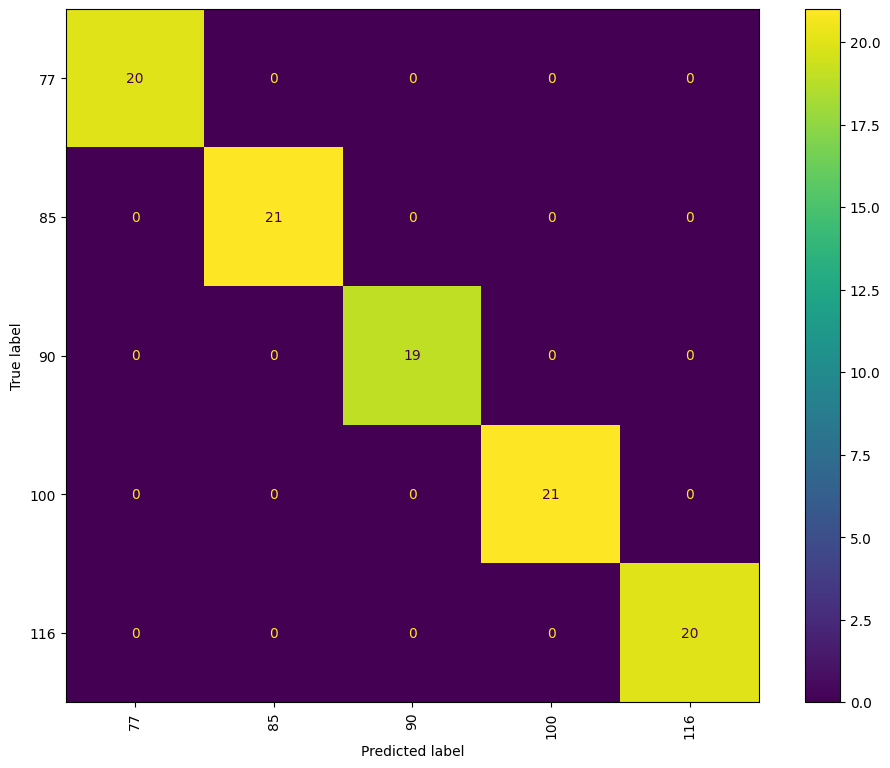

{'Embedding': 'Sentence-Tranformers',
 'Accuracy': 100.0,
 'Precision': 100.0,
 'Recall': 100.0,
 'F1': 100.0}

In [ ]:
res = get_results("Sentence-Tranformers", test_df['predicted_token'], test_df['token'])
res

In [ ]:
ST_emb = get_model_results(res)
ST_emb

,Accuracy,Precision,Recall,F1
Embedding,,,,
Sentence-Tranformers,100.0,100.0,100.0,100.0


In [ ]:
import random

choices = list(range(100000))  # Create a list of numbers from 0 to 99999
random_choice = random.choices(choices)[0]

document_collection_emb = add_collection(random_choice, UseOwnembedding=True)

# USE BY-DEAFULT EMBEDDING (Sentence-Transformer)

PREDICTION = []
for query in tqdm(test_df['clean_text']):
    input_em = get_bert_embedding(query).tolist()
    results = document_collection_emb.query(
        query_embeddings=[input_em],
        n_results=1
    )
    predicted_token = pd.DataFrame(results['metadatas'][0]).value_counts().index[0][0]
    PREDICTION.append(predicted_token)

test_df['predicted_token'] = PREDICTION

  0%|          | 0/101 [00:00<?, ?it/s]


Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-Score: 100.0%

Classification Report:
              precision    recall  f1-score   support

          77       1.00      1.00      1.00        20
          85       1.00      1.00      1.00        21
          90       1.00      1.00      1.00        19
         100       1.00      1.00      1.00        21
         116       1.00      1.00      1.00        20

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101


Confusion Matrix:


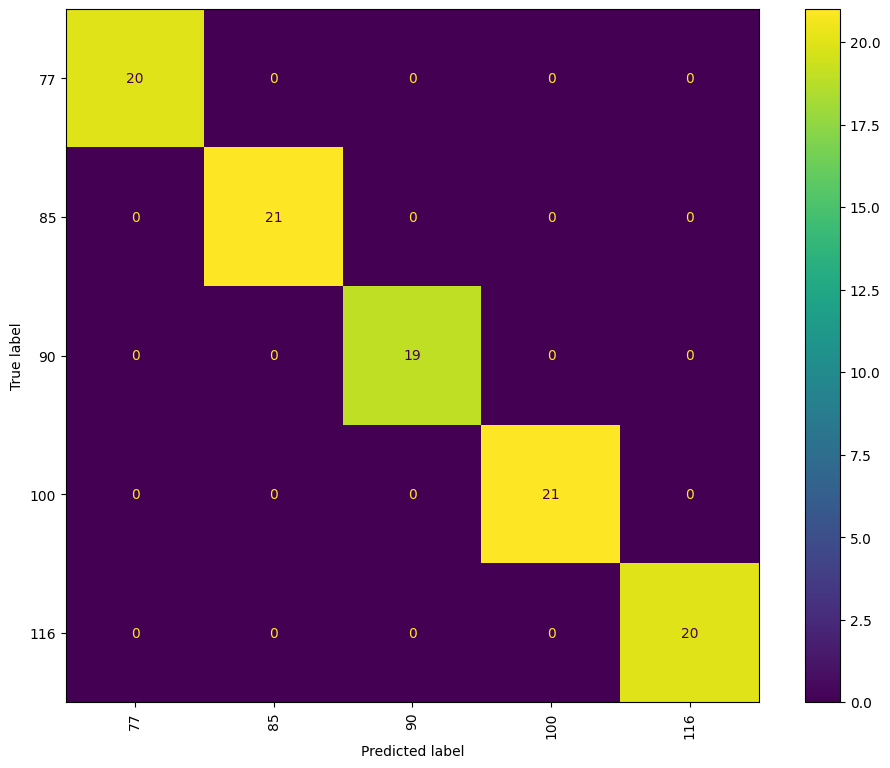

In [ ]:
res = get_results("Bert-Embedding", test_df['predicted_token'], test_df['token'])

In [ ]:
BERT_emb = get_model_results(res)
BERT_emb

,Accuracy,Precision,Recall,F1
Embedding,,,,
Bert-Embedding,100.0,100.0,100.0,100.0


In [ ]:
pd.concat([ST_emb, BERT_emb])

,Accuracy,Precision,Recall,F1
Embedding,,,,
Sentence-Tranformers,100.0,100.0,100.0,100.0
Bert-Embedding,100.0,100.0,100.0,100.0


In [ ]:
# !pip install --upgrade transformers

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch

def generate_roberta_embedding(text):
    model_name = 'roberta-base'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaModel.from_pretrained(model_name)

    # Set the device to 'cuda' if available, otherwise use 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Tokenize the input text and convert it to input tensors
    max_length = tokenizer.model_max_length - 2  # Account for special tokens
    input_tokens = tokenizer.encode_plus(text, add_special_tokens=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_tokens = {key: tensor.to(device) for key, tensor in input_tokens.items()}

    # Generate the BERT embeddings
    with torch.no_grad():
        model.eval()
        output = model(**input_tokens)

    # Access the embedding for the first token ([CLS] token)
    embedding = output.last_hidden_state[:, 0, :]

    # Convert the embedding to a numpy array
    embedding = embedding.cpu().numpy()

    return embedding[0]

In [ ]:
# embedding = generate_roberta_embedding("This is a sample text.")
# embedding

In [ ]:
train_df['Roberta_word_embedding'] = [generate_roberta_embedding(text) for text in tqdm(train_df['clean_text'])]

  0%|          | 0/403 [00:00<?, ?it/s]

In [ ]:
documents = []
embeddings = []
metadatas = []
ids = []

for index, token, text,emb in tqdm(zip(train_df['index'],train_df['token'],train_df['clean_text'],train_df['Roberta_word_embedding'])):
    documents.append(text)
    embeddings.append(emb.tolist())
    metadatas.append({'token': token})
    ids.append(str(index + 1))

0it [00:00, ?it/s]

In [ ]:
import random

choices = list(range(100000))  # Create a list of numbers from 0 to 99999
random_choice = random.choices(choices)[0]

document_collection_emb = add_collection(random_choice, UseOwnembedding=True)

# USE BY-DEAFULT EMBEDDING (Sentence-Transformer)

PREDICTION = []
for query in tqdm(test_df['clean_text']):
    input_em = get_bert_embedding(query).tolist()
    results = document_collection_emb.query(
        query_embeddings=[input_em],
        n_results=1
    )
    predicted_token = pd.DataFrame(results['metadatas'][0]).value_counts().index[0][0]
    PREDICTION.append(predicted_token)

test_df['predicted_token'] = PREDICTION

  0%|          | 0/101 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarni


Accuracy: 23.7624%
Precision: 23.1579%
Recall: 8.1852%
F1-Score: 11.3122%

Classification Report:
              precision    recall  f1-score   support

          77       0.00      0.00      0.00         0
          85       1.00      0.26      0.41        81
          90       0.16      0.15      0.15        20
         100       0.00      0.00      0.00         0
         116       0.00      0.00      0.00         0

    accuracy                           0.24       101
   macro avg       0.23      0.08      0.11       101
weighted avg       0.83      0.24      0.36       101


Confusion Matrix:


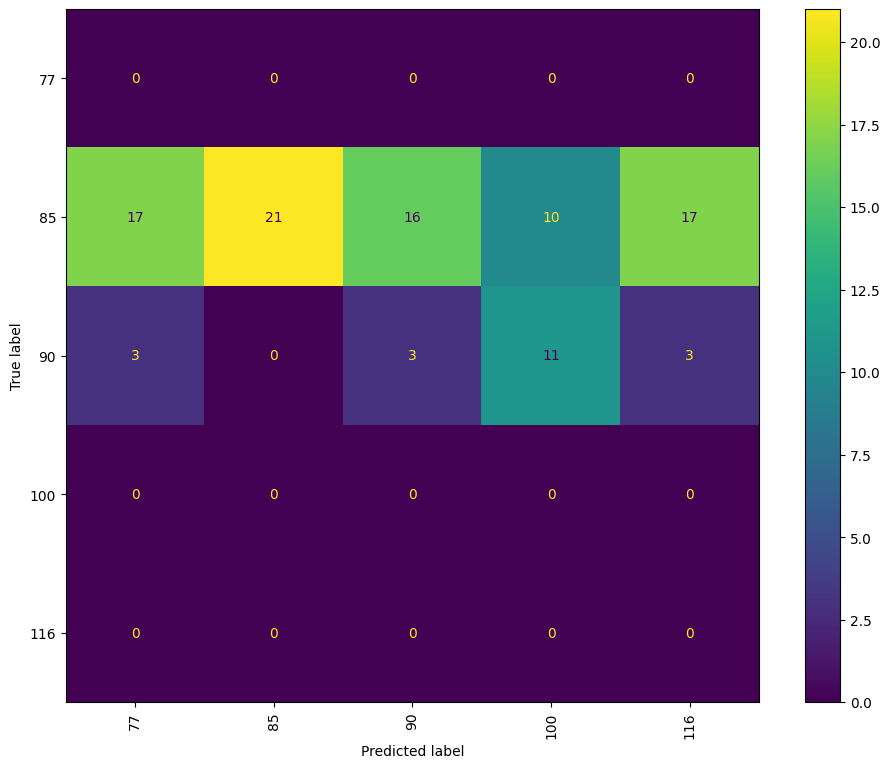

In [ ]:
res = get_results("RoBerta-Embedding", test_df['predicted_token'], test_df['token'])

In [ ]:
RoBERT_emb = get_model_results(res)
RoBERT_emb

,Accuracy,Precision,Recall,F1
Embedding,,,,
RoBerta-Embedding,23.7624,23.1579,8.1852,11.3122


In [ ]:
pd.concat([ST_emb, BERT_emb, RoBERT_emb])

,Accuracy,Precision,Recall,F1
Embedding,,,,
Sentence-Tranformers,100.0000,100.0000,100.0000,100.0000
Bert-Embedding,100.0000,100.0000,100.0000,100.0000
RoBerta-Embedding,23.7624,23.1579,8.1852,11.3122


In [ ]:
# y_test.value_counts()

In [ ]:
# results = document_collection_emb.query(
#     query_texts=test_df['clean_text'][1],
#     n_results=5
# )
# results

In [ ]:
# # USE BY-DEAFULT EMBEDDING (Sentence-Transformer)

# PREDICTION = []
# for query in tqdm(test_df['clean_text']):
#     results = document_collection_emb.query(
#         query_texts=query,
#         n_results=1
#     )
#     predicted_token = pd.DataFrame(results['metadatas'][0]).value_counts().index[0][0]
#     PREDICTION.append(predicted_token)

In [ ]:
# test_df['predicted_token'] = PREDICTION